# Word Analogy

In this section we compare the GloVe embedding analogy scores on the Google Analogy datasett. We then reduce its dimension and compare the anlogy score as a function of the embedding dimension.


When given a pair of words $a$ and $a^*$ and a third word $b$,
the analogy relationship between $a$ and $a^*$ can be used to
find the corresponding word $b^*$ to $b$. Mathematically, it is
expressed as

$a : a^*$ :: $b : $__

where the blank is $b^*$. One example could be
write : writing :: read : reading.
The 3CosAdd method solves for $b^*$ using the following
equation:

$b^* = argmax_{b'}(cos(b', a^* - a + b))$

Thus, high cosine similarity means that vectors share a
similar direction.

## 1. Imports

In [ ]:
!pip install --q wget

# general
import os
import gc
import time
import warnings

# ML
import numpy as np
import pandas as pd
from sklearn.random_projection import SparseRandomProjection

# DL
import torch

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# misc
import wget
import zipfile

warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) # set default size of plots
sns.set_style('whitegrid')

  Preparing metadata (setup.py) ... done


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## 2. Data Preparation

Importing the Google Analogy dataset

In [ ]:
if not os.path.exists('questions-words.txt'):
  wget.download('https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt')

In [ ]:
categories = {'names': [], 'df': []}

with open('questions-words.txt', 'r') as f:
  lines = f.readlines()

for line in lines:
  if line.startswith(':'):
    categories['names'].append(line.strip(': \r\n'))
    categories['df'].append({'a1': [], 'a2': [], 'b1': [], 'b2': []})

    continue

  a1, a2, b1, b2 = line.lower().strip('\r\n').split(' ')

  categories['df'][-1]['a1'].append(a1)
  categories['df'][-1]['a2'].append(a2)
  categories['df'][-1]['b1'].append(b1)
  categories['df'][-1]['b2'].append(b2)

categories['df'] = [pd.DataFrame(i) for i in categories['df']]
categories['sizes'] = [len(i) for i in categories['df']]

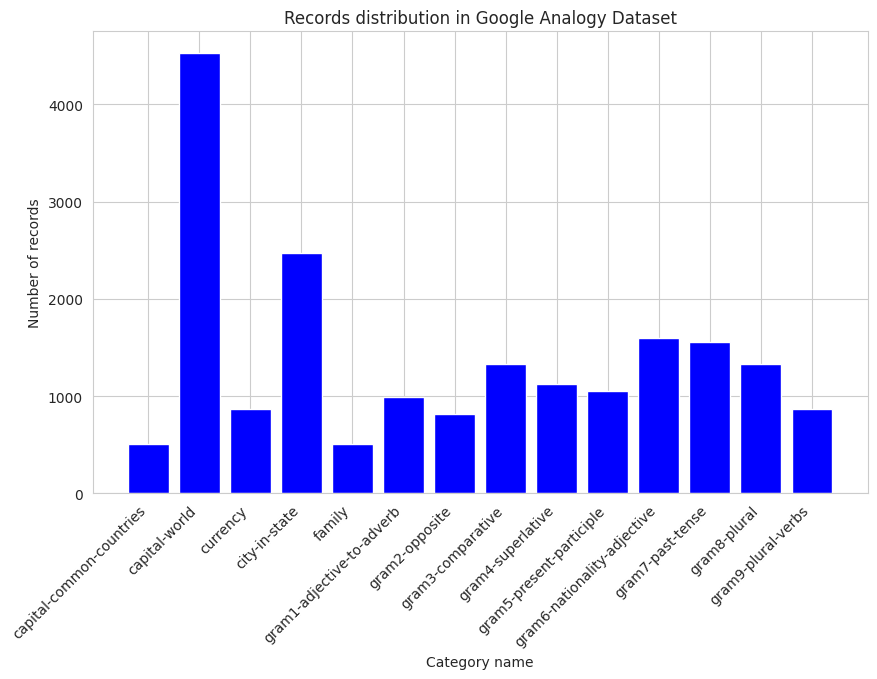

In [ ]:
plt.bar(categories['names'], categories['sizes'], color='b')
plt.xlabel('Category name')
plt.ylabel('Number of records')
plt.xticks(ha='right', rotation=45)
plt.title('Records distribution in Google Analogy Dataset')
plt.show()

In [ ]:
categories['df'] = [df.sample(n=500) for df in categories['df']]
all_quads_df = pd.concat(categories['df'])

print(f'There are {sum(categories["sizes"])} records in the dataset, we use {len(all_quads_df)} records')
all_quads_df.sample(n=20).head()

There are 19544 records in the dataset, we use 7000 records


,a1,a2,b1,b2
1136,pig,pigs,eagle,eagles
782,sure,unsure,reasonable,unreasonable
390,son,daughter,husband,wife
973,vanish,vanishing,increase,increasing
490,look,looking,sit,sitting


In [ ]:
all_words = pd.concat([all_quads_df['a1'], all_quads_df['a2'], all_quads_df['b1'], all_quads_df['b2']]).unique()
print(f'There are {len(all_words)} unique words in the dataset.')

There are 905 unique words in the dataset.


Importing the GloVe embedding

In [ ]:
if not os.path.exists('glove.6B.zip'):
  wget.download('https://nlp.stanford.edu/data/glove.6B.zip')

with zipfile.ZipFile('glove.6B.zip', 'r') as zip:
    zip.extract('glove.6B.300d.txt')


In [ ]:
glove_dict = {}
glove_dict_reverse_index = {}
data_glove_weights = {}

with open('glove.6B.300d.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
      values = line.strip('\r\n').split(' ')

      glove_dict[values[0]] = i
      glove_dict_reverse_index[i] = values[0]
      if values[0] in all_words:
        data_glove_weights[values[0]] = np.array(values[1:], dtype=np.float)

In [ ]:
all_words_dict = {word: glove_dict.get(word, None) for word in all_words}
all_words_dict_reverse_index = {i: word for word, i in all_words_dict.items()}

words_without_embeddings = list(filter(lambda w: all_words_dict[w] is None, all_words_dict.keys()))

print('words without embeddings:')
words_without_embeddings

words without embeddings:


[]

## 3. Baseline Experiment

In [ ]:
def embed_word(word, embedding_matrix=data_glove_weights):
  return embedding_matrix[word]

def embed_df(df, embedding_func=embed_word, normalize=True):
  df_embedded = df.copy()
  df_embedded['a1'] = df_embedded['a1'].apply(embedding_func)
  df_embedded['a2'] = df_embedded['a2'].apply(embedding_func)
  df_embedded['b1'] = df_embedded['b1'].apply(embedding_func)

  a1_matrix = np.stack(df_embedded['a1'].values.tolist())
  a2_matrix = np.stack(df_embedded['a2'].values.tolist())
  b1_matrix = np.stack(df_embedded['b1'].values.tolist())

  if normalize:
    a1_matrix = (a1_matrix.T / np.linalg.norm(a1_matrix, axis=1)).T
    a2_matrix = (a2_matrix.T / np.linalg.norm(a2_matrix, axis=1)).T
    b1_matrix = (b1_matrix.T / np.linalg.norm(b1_matrix, axis=1)).T

  del df_embedded
  return a1_matrix, a2_matrix, b1_matrix

a1_matrix, a2_matrix, b1_matrix = embed_df(all_quads_df)

In [ ]:
def torch_to_numpy(x):
  ''' overiding variable to save memory '''
  x = x.numpy()
  return x

def numpy_to_torch(x):
  ''' overiding variable to save memory '''
  x = torch.from_numpy(x)
  return x


def analogy_score(a1, a2, b1, vocab=glove_dict, chunks=4, transform=None):
  chunk_size = int(len(vocab) / chunks)
  curr_score = (torch.zeros(a1.shape[0]) - 10000).to(DEVICE)
  curr_indices = torch.zeros(a1.shape[0], dtype=torch.long).to(DEVICE)

  a1 = numpy_to_torch(a1)
  a2 = numpy_to_torch(a2)
  b1 = numpy_to_torch(b1)

  for i in range(chunks):
    weights = []

    with open('glove.6B.300d.txt', 'r') as f:
      lines = f.readlines()[i * chunk_size : (i + 1) * chunk_size]

      for line in lines:
        values = line.strip('\r\n').split(' ')
        weights.append(np.array(values[1:], dtype=np.float))

    weights = np.stack(weights, axis=0)
    weights = transform(weights) if transform is not None else weights
    weights = (weights.T / np.linalg.norm(weights, axis=1)).T

    a2_on_device = a2.to(DEVICE)
    a1_on_device = a1.to(DEVICE)
    b1_on_device = b1.to(DEVICE)
    analogy_ref = a2_on_device - a1_on_device + b1_on_device

    weights_on_device = numpy_to_torch(weights).to(DEVICE)
    score = torch.matmul(analogy_ref, weights_on_device.T)

    del analogy_ref, weights_on_device

    max_score = torch.max(score, dim=1)

    # update the currnet max score and replace indices where the max score changed
    curr_score = torch.maximum(curr_score, max_score.values)
    indices_mask = curr_score == max_score.values
    curr_indices[indices_mask] = max_score.indices[indices_mask] + i * chunk_size

  a1 = torch_to_numpy(a1)
  a2 = torch_to_numpy(a2)
  b1 = torch_to_numpy(b1)

  return torch_to_numpy(curr_indices.cpu())

In [ ]:
torch.cuda.empty_cache()
gc.collect()

4463

In [ ]:
indices = analogy_score(a1_matrix, a2_matrix, b1_matrix)

torch.cuda.empty_cache()
gc.collect()

12

In [ ]:
all_quads_df['b2 pred'] = [glove_dict_reverse_index[i] for i in indices]
baseline_accuracy = len(all_quads_df[all_quads_df['b2'] == all_quads_df['b2 pred']]) / len(all_quads_df) * 100

print(f'The Accuracy of GloVe embedding on the analogy dataset is {baseline_accuracy}%')

print('predictions sample:')
all_quads_df.sample(n=20).head(7)

The Accuracy of GloVe embedding on the analogy dataset is 18.057142857142857%
predictions sample:


,a1,a2,b1,b2,b2 pred
218,canada,dollar,russia,ruble,dollar
1051,malta,maltese,japan,japanese,japanese
387,boston,massachusetts,miami,florida,miami
938,tasty,tastiest,great,greatest,greatest
786,walk,walks,describe,describes,describe
847,vietnam,dong,europe,euro,europe
1513,walking,walked,sleeping,slept,sleeping


## 4. JLT Embedding Experiment

In this section we apply the Johnson-Lindenstrauss transformation on the GloVe embedding and compute the cosine similarity of datasets.


JL is a dimensionality reduction method that preserves Euclidean distance by applying random projection.
Given $\epsilon \in (0, 1)$, a set $X \subset R^D $ there exists a linear map $f : R^D → R^K$ such that:

$$ (1 - \epsilon) ||v - u||_2 \le || f(v) - f(u) ||_2 \le (1 + \epsilon) ||v - u||_2$$

for all $u , v \in X$.

We apply the transformation on the embedding and then compute the 3CosAdd of the reduced vectors.

In [ ]:
components = [300, 250, 200, 150, 100, 75, 60, 50, 30]

def run_jl_experiment(components, df, baseline_accuracy, plot_options=None, iterations=10):
  accs = [baseline_accuracy]

  for component in components:
    accumulating_acc = 0.0

    if component == 300:
      continue

    for _ in range(iterations):
      sp = SparseRandomProjection(n_components = component)
      reduced_weights = {k: sp.fit_transform([v]).reshape(1,-1) for k, v in data_glove_weights.items()}
      embedding_func = lambda word: np.squeeze(embed_word(word, reduced_weights))

      a1_matrix, a2_matrix, b1_matrix = embed_df(df, embedding_func)

      torch.cuda.empty_cache()
      gc.collect()

      indices = analogy_score(a1_matrix, a2_matrix, b1_matrix, transform=sp.fit_transform)

      res_df = df.copy()
      res_df['b2 pred'] = [glove_dict_reverse_index[i] for i in indices]

      accumulating_acc += len(res_df[res_df['b2'] == res_df['b2 pred']]) / len(res_df) * 100

      del a1_matrix, a2_matrix, b1_matrix, res_df

    accs.append(accumulating_acc / iterations)


  if plot_options is not None:
    plt.plot(components, accs, 'bo-')
    plt.plot(components, [baseline_accuracy] * len(components), 'r--')
    plt.xlabel('Components Number')
    plt.ylabel('Accuracy')
    plt.legend(['Exp results', 'Baseline result'])
    plt.title(plot_options['title'])
    plt.show()


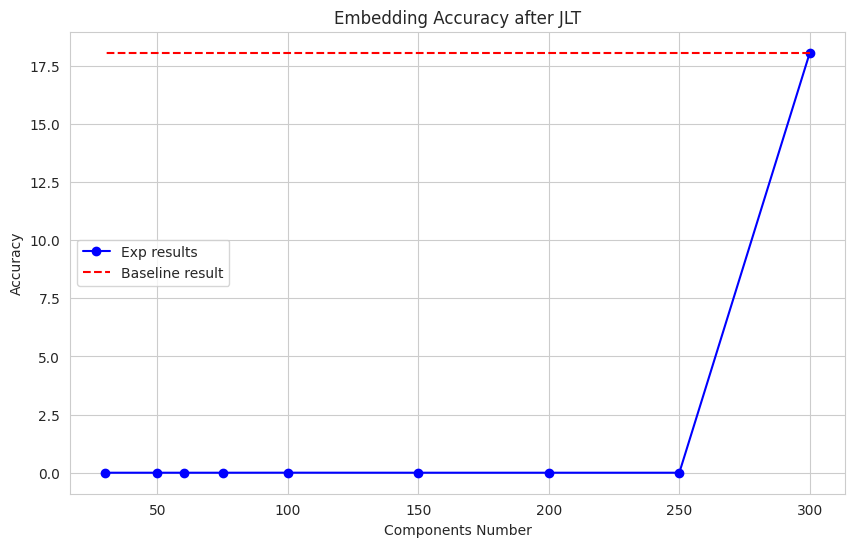

In [ ]:
run_jl_experiment(components, all_quads_df, baseline_accuracy, {'title': 'Embedding Accuracy after JLT'})

## 5. CSSRPL Embedding Experiment

In this section we apply the CSSRPL transformation on the GloVe embedding and compute the cosine similarity of datasets.


In the *Improving Sign-Random-Projection via Count Sketch* [[1](https://openreview.net/pdf?id=StLUq88jqx9)] paper the authors propose two ways to improve Sign-Random-Projection (SRP) or SimHash algorithms which provides an unbiased estimate for pairwise cosine similarity of vectors.

<br>

The CSSRP algorithm is based on the sketch proposed in [[2](https://www.cs.princeton.edu/courses/archive/spr04/cos598B/bib/CharikarEstim.pdf)] which works as follows:

let $A \in R^{K \times D}$ be a random linear operator where $\forall a_{ij} \sim 𝒩 \ (0,1)$ and let $a,b \in R^D$.

Now let $\alpha, \beta \in \{0,1\}^K$ such that $\alpha_i = \Bbb{I} _{ Aa_i > 0}$ and $\beta_i =  \Bbb{I}_{ Ab_i > 0}$ (meaning that the projection vectors get one when the product of the vector with the projection matrix row is positive). Now if we take the Hamming distance between $\alpha, \beta$ and multiply it by $\frac{\pi}{K}$ we get the angle between $a,b$:

$X = \frac{\pi}{K} \sum_{i=1}^{K} X^{(i)}$ where $ X^{(i)} =  \Bbb{I}_{ \alpha_i \ne \beta_i}$

$\theta_{(a,b)}=𝔼[X]$

which is equivalent to:

$\theta_{(a,b)}= \frac{\pi}{K} || \alpha - \beta ||_1$


<br>


The authors propose instead of applying the random projection $A$, sketching each input vector with Count Sketch (with $d$ rows and $w$ buckets in each row, altogether $d \cdot w = K$) and then continuing as mentioned before:

$\forall a,b \in R^D$ create Count sketches $\alpha, \beta \in ℤ^K$, then apply function $h( \cdot )$ on each sketch where $h$ takes each component of the input vector and returns 1 if it is positive, else 0. Then we compute:

$\theta_{(a,b)}= \frac{\pi}{K} || h(\alpha) - h(\beta) ||_1$

The paper shows that this is an unbiased estimate of the cosine similarity of any two vectors and furthermore, this result has smaller variance than the SRP.

<br>

In the second part of the paper, the authors suggest another improvement to the original algorithm- instead of using the random operator $A \in R^{K \times D}$ where $\forall a_{ij} \sim 𝒩 \ (0,1)$, they offer using a matrix $A' \in R^{K \times D}$ where each column has $l$ random entries which are $\{\pm1\}$ with probability $\frac{1}{2}$ and the rest of the matrix is $0$. The rest of the algorithm stays the same - projecting the vectors, applying the function $h( \cdot )$ and computing the Hamming distance.

<br>

We use the second technique and apply it on the GloVe embedding: for each two vectors $a,b$ we compute:
$cos(\theta_{(a,b)})= cos(\frac{\pi}{K} || h(\alpha) - h(\beta) ||_1)$

where $\alpha_i = \Bbb{I} _{ A'a_i > 0}$ and $\beta_i =  \Bbb{I}_{ A'b_i > 0}$
and then we can plug it into the 3CosAdd function.

In [ ]:
def cssrpl_analogy_score(a1, a2, b1, vocab=glove_dict, chunks=4, transform=None, component=np.pi):
  chunk_size = int(len(vocab) / chunks)
  curr_score = np.zeros(a1.shape[0]) - 10000
  curr_indices = np.zeros(a1.shape[0])

  for i in range(chunks):
    weights = []

    with open('glove.6B.300d.txt', 'r') as f:
      lines = f.readlines()[i * chunk_size : (i + 1) * chunk_size]

      for line in lines:
        values = line.strip('\r\n').split(' ')
        weights.append(np.array(values[1:], dtype=np.float))

    weights = np.stack(weights, axis=0)
    weights = transform(weights) if transform is not None else weights

    analogy_ref = a2 - a1 + b1
    score = np.zeros((analogy_ref.shape[0], weights.shape[1]))

    for j in range(score.shape[0]):
      for k in range(score.shape[1]):
        score[j, k] = np.cos((np.pi / component) * np.linalg.norm(analogy_ref[j, :] - weights[k, :], ord=1))

    del analogy_ref, weights

    max_score = score.max(axis=1)
    max_score_indices = score.argmax(axis=1)

    # update the currnet max score and replace indices where the max score changed
    curr_score = np.maximum(curr_score, max_score)
    indices_mask = curr_score == max_score
    curr_indices[indices_mask] = max_score_indices[indices_mask] + i * chunk_size

  return curr_indices

In [ ]:
components = [300, 250, 200, 150, 100, 75, 60, 50, 30]

def run_cssrpl_experiment(components, df, baseline_accuracy, plot_options=None, iterations=10):
  accs = [[baseline_accuracy], [baseline_accuracy], [baseline_accuracy]]
  l_values = [2, 3, 4]

  for i, l in enumerate(l_values):
    for component in components:
      accumulating_acc = 0.0

      if component == 300:
        continue

      for _ in range(iterations):
        projection_matrix = np.zeros((component, 300))

        for col in range(component):
          non_zero_indices = np.random.choice(component, l)
          for row in non_zero_indices:
            projection_matrix[row, col] = np.random.randint(2) * 2 - 1


        projection = lambda weights: np.where(weights @ projection_matrix.T > 0, 1, 0)

        reduced_weights = {k: projection(v).reshape(1,-1) for k, v in data_glove_weights.items()}
        embedding_func = lambda word: np.squeeze(embed_word(word, reduced_weights))

        a1_matrix, a2_matrix, b1_matrix = embed_df(df, embedding_func, normalize=False)

        torch.cuda.empty_cache()
        gc.collect()

        indices = cssrpl_analogy_score(a1_matrix, a2_matrix, b1_matrix, transform=projection, component=component)

        res_df = df.copy()
        res_df['b2 pred'] = [glove_dict_reverse_index[i] for i in indices]

        accumulating_acc += len(res_df[res_df['b2'] == res_df['b2 pred']]) / len(res_df) * 100

        del a1_matrix, a2_matrix, b1_matrix, res_df

      accs[i].append(accumulating_acc / iterations)

  if plot_options is not None:
    plt.plot(components, accs[0], 'bo-')
    plt.plot(components, accs[1], 'go-')
    plt.plot(components, accs[2], 'co-')
    plt.plot(components, [baseline_accuracy] * len(components), 'r--')
    plt.xlabel('Components Number')
    plt.ylabel('Accuracy')
    plt.legend(['Exp results l=2', 'Exp results l=3', 'Exp results l=4', 'Baseline result'])
    plt.title(plot_options['title'])
    plt.show()


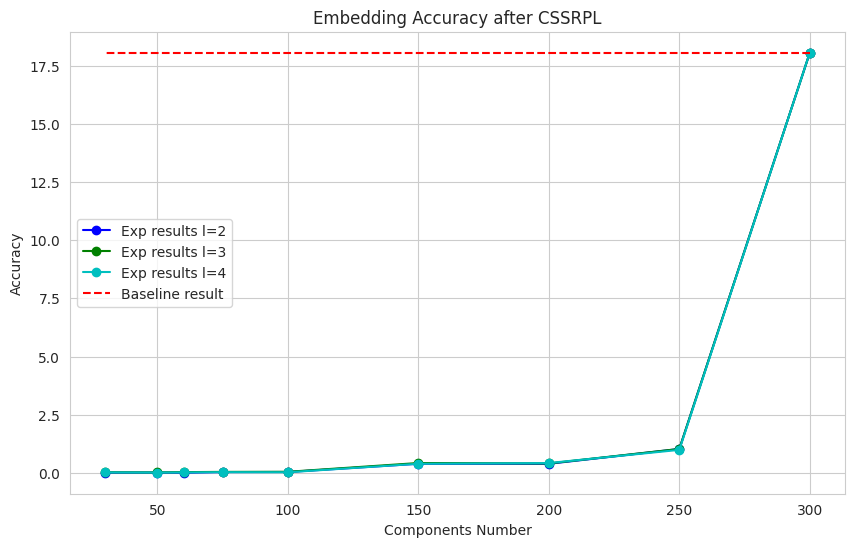

In [ ]:
run_cssrpl_experiment(components, all_quads_df, baseline_accuracy, {'title': 'Embedding Accuracy after CSSRPL'})

# Refrences

[1] Dubey, Punit Pankaj, et al. "Improving sign-random-projection via count sketch." Uncertainty in Artificial Intelligence. PMLR, 2022.

[2] Moses S Charikar. Similarity estimation techniques from
rounding algorithms. In Proceedings of the thiry-fourth
annual ACM symposium on Theory of computing, pages
380-388, 2002.